In [55]:
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, classification_report, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, KFold, LeaveOneOut
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, auc
from sklearn.decomposition import PCA
import umap
import json
import cupy
from tqdm import tqdm
from gtfparse import read_gtf

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm

from sklearn import svm
from xgboost import XGBRegressor
from scipy.stats import spearmanr

from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.metrics import mean_absolute_error as MAE


In [56]:
transcripts = {
    "HEART": {
        "male": [],
        "female": []
    }, 
    "BRAIN0": {
        "male": [],
        "female": []
    }, 
    "BRAIN1": {
        "male": [],
        "female": []
    }, 
}

In [57]:
fdir_raw = Path("../data/raw/")
fdir_processed = Path("../data/interim")
fdir_traintest = Path("../data/processed") / 'sex'
fdir_external = Path("../data/external")
ml_models_fdir = Path("../models")

use_CV = True

model_type = 'catboost'
model_type = 'xgboost'
# model_type = 'knn'

feature_importance_method = 'native'
feature_importance_method = 'SHAP'

n_features = 0

# value_to_predict = 'population'
value_to_predict = 'Age'

organ = "HEART"
# organ = "BRAIN0"
organ = "BRAIN1"
# 
sex = 'male'
sex = 'female'

n_opt_features = {
    "HEART": {
        "male": 9,
        "female": 11
    }, 
    "BRAIN0": {
        "male": 7,
        "female": 7
    }, 
    "BRAIN1": {
        "male": 17,
        "female": 8
    }, 
}

# transcripts[organ] = {}
# transcripts[organ][sex] = []


In [58]:
fdir_processed / f'{organ}.preprocessed.h5'

PosixPath('../data/interim/BRAIN1.preprocessed.h5')

In [59]:
# select by by variance

gtf_rawdata = read_gtf(fdir_raw / 'all_transcripts_strigtie_merged.gtf')
gtf_data = gtf_rawdata.to_pandas()
gtf_data = gtf_data.set_index('transcript_id')
gtf_data['transcript_id'] = gtf_data.index
gtf_data

INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'exon_number', 'gene_name', 'ref_gene_id']


,seqname,source,feature,start,end,score,strand,frame,gene_id,exon_number,gene_name,ref_gene_id,transcript_id
transcript_id,,,,,,,,,,,,,
MSTRG.1.1,GL000008.2,StringTie,transcript,1,17013,1000.0,NaN,0,MSTRG.1,,,,MSTRG.1.1
MSTRG.1.1,GL000008.2,StringTie,exon,1,17013,1000.0,NaN,0,MSTRG.1,1,,,MSTRG.1.1
MSTRG.2.1,GL000008.2,StringTie,transcript,199413,199638,1000.0,NaN,0,MSTRG.2,,,,MSTRG.2.1
MSTRG.2.1,GL000008.2,StringTie,exon,199413,199638,1000.0,NaN,0,MSTRG.2,1,,,MSTRG.2.1
MSTRG.3.1,GL000009.2,StringTie,transcript,60101,61775,1000.0,NaN,0,MSTRG.3,,,,MSTRG.3.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENST00000711259.1,chrY,HAVANA,exon,57062156,57062405,NaN,+,0,ENSG00000292365.1,1,DPH3P2,,ENST00000711259.1
ENST00000711266.1,chrY,HAVANA,transcript,57165512,57165845,NaN,-,0,ENSG00000292367.1,,ELOCP24,ENSG00000292367.1,ENST00000711266.1
ENST00000711266.1,chrY,HAVANA,exon,57165512,57165845,NaN,-,0,ENSG00000292367.1,1,ELOCP24,,ENST00000711266.1


In [60]:
data = pd.read_hdf(fdir_processed / f'{organ}.preprocessed.h5', key="data")
data_header = pd.read_hdf(fdir_processed / f'{organ}.preprocessed.h5', key="header")

# data = data.iloc[:, np.argwhere(np.sum(data > 0, axis=0) > 18).ravel()]


if organ == "BRAIN1":
    data_header['sex'] = data_header['gender'] 


data_male = data.loc[data_header['sex'] == "male"]
data_female = data.loc[data_header['sex'] == "female"]

data_header_male = data_header.loc[data_header['sex'] == "male"]
data_header_female = data_header.loc[data_header['sex'] == "female"]

# data_male = data.loc[data_header['disease_state'] == "psychosis_schizophrenia"]
# data_female = data.loc[data_header['disease_state'] == "match control"]

# data_header_male = data_header.loc[data_header['disease_state'] == "psychosis_schizophrenia"]
# data_header_female = data_header.loc[data_header['disease_state'] == "match control"]



# fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
# sns.regplot(y=data[data.columns[0]], x=data_header['Age'], ax=axs[0], label='male+female')
# sns.regplot(y=data[data.columns[0]].loc[data_header['sex'] == 'male'], x=data_header['Age'].loc[data_header['sex'] == 'male'], ax=axs[1], 
#             label='male')
# sns.regplot(y=data[data.columns[0]].loc[data_header['sex'] == 'female'], x=data_header['Age'].loc[data_header['sex'] == 'female'], ax=axs[1], 
#             label='female')
# axs[0].legend()
# axs[1].legend()

data_both = data.copy(deep=True)
data_header_both = data_header.copy(deep=True)

data = data.loc[data_header['sex'] == sex]
data_header = data_header.loc[data_header['sex'] == sex]

# gtf_data = gtf_data.loc[data.columns].drop_duplicates("transcript_id")


In [61]:
# import anndata as ad
# import scanpy as sc

# adata = ad.AnnData(data)
# adata.var = gtf_data
# adata.obs = data_header


In [62]:
rhos_male = []
pvalues_male = []
rhos_female = []
pvalues_female = []

for i in tqdm(range(data_male.values.shape[1])):
    # rho, pvalue = spearmanr(X[:, i], y)
    rho, pvalue = spearmanr(data_male.values[:, i], data_header_male['Age'].values)
    rhos_male.append(rho)
    pvalues_male.append(pvalue)
    
for i in tqdm(range(data_female.values.shape[1])):
    rho, pvalue = spearmanr(data_female.values[:, i], data_header_female['Age'].values)
    rhos_female.append(rho)
    pvalues_female.append(pvalue)
# rho, pvalue = spearmanr(X, y.values.reshape(1,-1), axis=1)
rhos_male = np.array(rhos_male)
rhos_female = np.array(rhos_female)

  0%|          | 0/17915 [00:00<?, ?it/s]/tmp/ipykernel_265597/2184972271.py:13: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, pvalue = spearmanr(data_female.values[:, i], data_header_female['Age'].values)
100%|██████████| 17915/17915 [00:15<00:00, 1180.55it/s]


In [63]:
from statsmodels.stats.multitest import multipletests

reject, pvals_corrected, sidac, bonf = multipletests(pvalues_male, alpha=0.05)
# pvalues_male, pvals_corrected
np.argwhere(reject)

array([[1728]])

nan
0.20023947206063547
nan


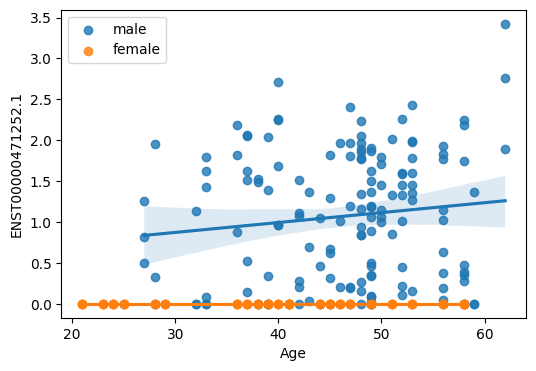

In [64]:
# rhos_male_sign = rhos_male > 0
# rhos_female_sign = rhos_female > 0

# diff_corr_ids = np.where(np.logical_xor(rhos_male_sign, rhos_female_sign))
# diff_corr_ids_sorted = np.argsort(np.abs(rhos_female[diff_corr_ids]))[::-1]

diff_corr_ids_sorted = np.argsort((rhos_male - rhos_female)**2)[::-1]

# print(diff_corr_ids_sorted)
index = 2
# diff_corr_ids_sorted[index] = 1728

print((rhos_male - rhos_female)[diff_corr_ids_sorted[index]])

print(pvalues_male[diff_corr_ids_sorted[index]])
print(pvalues_female[diff_corr_ids_sorted[index]])

fig, axs = plt.subplots(figsize=(6, 4))
# sns.regplot(y=data[data.columns[sorted_corr_ids[0]]], x=data_header['Age'], ax=axs[0], label='male+female')
sns.regplot(y=data_male[data_male.columns[diff_corr_ids_sorted[index]]], x=data_header_male['Age'], ax=axs, label='male')
sns.regplot(y=data_female[data_female.columns[diff_corr_ids_sorted[index]]], x=data_header_female['Age'], ax=axs, label='female')
axs.legend()


In [65]:
# eval_organ = "BRAIN0"
# eval_organ = "BRAIN1"
# eval_organ = 'HEART'
eval_organ = organ

fname = next((fdir_external / eval_organ / 'reg').glob("*processed.h5"))
fname = fname.name
data_eval = pd.read_hdf(fdir_external / eval_organ / 'reg' / fname, index_col=0)
data_eval_header = pd.read_csv(fdir_external / eval_organ / 'reg' / 'SraRunTable.txt', sep=',')
data_eval_header.set_index("Run", inplace=True)

if eval_organ == "BRAIN1":
    data_eval_header['sex'] = data_eval_header['gender'] 

data_eval_header = data_eval_header.loc[data_eval_header['sex'] == sex]
data_eval = data_eval.loc[(data_eval_header['sex'] == sex).index]


In [66]:
common_transcripts = data.columns.intersection(data_eval.columns)

data_eval = data_eval[common_transcripts]
data = data[common_transcripts]
data

,ENST00000003912.7,ENST00000004103.8,ENST00000005340.10,ENST00000006658.11,ENST00000011473.6,ENST00000012134.7,ENST00000019019.6,ENST00000040877.2,ENST00000043402.8,ENST00000070846.11,...,MSTRG.9920.54,MSTRG.9929.23,MSTRG.9929.7,MSTRG.993.1,MSTRG.9947.1,MSTRG.9948.7,MSTRG.9968.1,MSTRG.9975.19,MSTRG.9996.5,MSTRG.9996.8
SRR19147434,0.035113,0.000000,0.000000,0.000000,2.541312,1.165357,0.000000,0.000000,0.000000,1.324862,...,0.439607,0.412652,0.962864,0.161302,0.481970,0.112381,0.045710,2.256034,1.917703,0.000000
SRR19147442,0.000000,0.794052,0.639125,2.711348,1.775380,0.000000,0.064382,0.000000,0.050570,0.000000,...,0.402106,0.149464,0.113675,1.355619,0.250905,0.377805,0.050970,0.017744,2.300946,0.799852
SRR19147446,0.074349,0.753136,0.708915,0.000000,1.378070,2.801095,0.000000,0.000000,0.000000,0.493102,...,0.248560,0.000000,0.862037,1.057980,0.000000,0.358265,0.618596,0.000000,1.235949,0.619376
SRR19147447,0.090973,0.000000,0.477256,0.000000,2.109113,0.577190,0.000000,0.404090,0.060731,1.621448,...,0.361008,0.000000,0.109881,0.000000,0.791788,1.235325,1.264548,1.040307,0.000000,0.000000
SRR19147449,3.216066,0.000000,0.231375,2.159864,1.795123,2.483123,0.205097,0.644347,0.000000,1.492418,...,0.000000,0.617182,0.000000,0.000000,0.301595,1.491003,0.203924,0.000000,1.878485,0.302905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR19147639,0.018694,1.439938,0.000000,0.871802,0.812680,1.920269,1.853739,0.373347,1.485324,0.352790,...,0.682039,0.105977,0.048169,0.440572,0.138066,1.424093,0.904682,0.000000,1.860002,0.379787
SRR19147640,0.067368,0.853492,0.959471,0.000000,2.188290,0.368054,0.105354,0.923482,1.733386,0.000000,...,0.000000,0.172310,0.131330,0.000000,0.000000,0.000000,0.118245,0.000000,0.000000,0.000000
SRR19147643,0.053578,0.871527,0.000000,1.673051,0.000000,0.000000,0.029692,0.000000,0.000000,0.051819,...,0.000000,0.000000,0.000000,0.990722,0.193961,1.102999,0.155117,0.000000,3.188317,0.601204
SRR19147645,0.018633,0.229080,0.795503,0.975072,3.027320,0.000000,0.279622,0.413792,1.840818,0.045711,...,0.000000,0.000000,0.123792,0.000000,0.742506,0.167535,0.050493,0.000000,1.644255,0.110735


In [67]:
rhos = []
pvalues = []

# y = data_header[value_to_predict]
# X = data.values

y = data_header.loc[data_header['sex'] == sex][value_to_predict]
X = data.loc[data_header['sex'] == sex].values


for i in tqdm(range(X.shape[1])):
    # rho, pvalue = spearmanr(X[:, i], y)
    rho, pvalue = spearmanr(X[:, i], y)
    rhos.append(rho)
    pvalues.append(pvalue)
# rho, pvalue = spearmanr(X, y.values.reshape(1,-1), axis=1)

reject, pvalues_corrected, sidac, bonf = multipletests(pvalues, alpha=0.05, method='fdr_bh')
np.argwhere(reject), np.argwhere(np.array(pvalues) < 0.05)

  0%|          | 0/17915 [00:00<?, ?it/s]/tmp/ipykernel_265597/191002482.py:13: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, pvalue = spearmanr(X[:, i], y)
100%|██████████| 17915/17915 [00:15<00:00, 1164.63it/s]


(array([[ 1192],
        [ 2322],
        [ 6338],
        [ 7764],
        [13612],
        [15043]]),
 array([[    5],
        [    8],
        [   10],
        ...,
        [17825],
        [17866],
        [17871]]))

In [68]:
# np.argwhere(np.array(pvalues) < 0.05).shape

# unsignificant_corr_ids = np.argwhere(np.array(pvalues_corrected) > 0.05)
unsignificant_corr_ids = np.argwhere(np.array(pvalues) > 0.05)

# unsignificant_corr_ids

rhos = np.array(rhos)
rhos[unsignificant_corr_ids] = 0
rhos[np.argwhere(X.mean(axis=0) == 0)] = 0


### Select by correlation value

In [69]:
# Select by correlation value

corr_threshold = 0.96
corr_threshold = 0.5
corr_threshold = 0.1

if np.abs(rhos).max() > corr_threshold:
    sorted_corr_border = np.argwhere(np.sort(np.abs(rhos))[::-1] > corr_threshold).max()
    sorted_corr_ids = np.argsort(np.abs(rhos))[::-1][:sorted_corr_border]
    # np.sort(np.abs(rhos))[::-1][:sorted_corr_border], sorted_corr_ids
else:
    sorted_corr_ids = []
sorted_corr_ids, sorted_corr_ids.shape

(array([13612,  6338, 15043, ...,  3858, 14748, 14580]), (1034,))

### Select by feature importance 

In [156]:
# # select by feature importance
# model = XGBRegressor(n_estimators=300, max_depth=4, )

# X = data.values
# y = data_header['Age'].loc[data_header['sex'] == sex].values

# # model.fit(RobustScaler().fit_transform(X),  y)
# model.fit(X,  y)
# importances = model.feature_importances_

# sorted_corr_ids = np.argsort(importances).ravel()[::-1][:50]

### Select by Scanpy variance

In [73]:
# select by by variance

gtf_rawdata = read_gtf(fdir_raw / 'all_transcripts_strigtie_merged.gtf')
gtf_data = gtf_rawdata.to_pandas()
gtf_data = gtf_data.set_index('transcript_id')
gtf_data['transcript_id'] = gtf_data.index

gtf_data = gtf_data.loc[data.columns].drop_duplicates("transcript_id")

gtf_data

KeyboardInterrupt: 

In [51]:
import anndata as ad
import scanpy as sc

adata = ad.AnnData(data)
adata.var = gtf_data
adata.obs = data_header



In [124]:
# disease_state
adata.obs[['DATASTORE filetype',
       'DATASTORE provider', 'DATASTORE region', 'disease_state', 'Experiment',
       'gender', 'Instrument', 'Library Name', 'library_size', 'LibraryLayout',
       'LibrarySelection', 'LibrarySource', 'manner_of_death', 'Organism',
       'patients_ID', 'PH', 'Platform', 'pmi', 'RACE', 'ReleaseDate',]]

,DATASTORE filetype,DATASTORE provider,DATASTORE region,disease_state,Experiment,gender,Instrument,Library Name,library_size,LibraryLayout,LibrarySelection,LibrarySource,manner_of_death,Organism,patients_ID,PH,Platform,pmi,RACE,ReleaseDate
SRR19147434,"run.zq,sra,fastq","ncbi,gs,s3","ncbi.public,gs.US,s3.us-east-1",psychosis_schizophrenia,SRX15214383,female,NextSeq 500,GSM6123999,37391426,PAIRED,cDNA,TRANSCRIPTOMIC,Suicide,Homo sapiens,843,7.1,ILLUMINA,17.1,White,2022-08-31T00:00:00Z
SRR19147442,"run.zq,fastq,sra","s3,ncbi,gs","gs.US,s3.us-east-1,ncbi.public",psychosis_schizophrenia,SRX15214375,female,NextSeq 500,GSM6123991,35214627,PAIRED,cDNA,TRANSCRIPTOMIC,Suicide,Homo sapiens,656,7.2,ILLUMINA,19.8,Black,2022-08-31T00:00:00Z
SRR19147446,"fastq,sra,run.zq","ncbi,s3,gs","s3.us-east-1,gs.US,ncbi.public",psychosis_schizophrenia,SRX15214372,female,NextSeq 500,GSM6123988,36844873,PAIRED,cDNA,TRANSCRIPTOMIC,Natural,Homo sapiens,587,7.0,ILLUMINA,16.9,Black,2022-08-31T00:00:00Z
SRR19147447,"fastq,run.zq,sra","gs,ncbi,s3","ncbi.public,s3.us-east-1,gs.US",match control,SRX15214371,female,NextSeq 500,GSM6123987,37287646,PAIRED,cDNA,TRANSCRIPTOMIC,Undetermined,Homo sapiens,1834,6.8,ILLUMINA,13.5,Black,2022-08-31T00:00:00Z
SRR19147449,"sra,fastq,run.zq","gs,s3,ncbi","gs.US,ncbi.public,s3.us-east-1",match control,SRX15214369,female,NextSeq 500,GSM6123985,37765803,PAIRED,cDNA,TRANSCRIPTOMIC,Natural,Homo sapiens,1789,6.8,ILLUMINA,13.7,White,2022-08-31T00:00:00Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR19147639,"run.zq,sra,fastq","gs,s3,ncbi","s3.us-east-1,ncbi.public,gs.US",match control,SRX15214179,female,NextSeq 500,GSM6123799,28012636,PAIRED,cDNA,TRANSCRIPTOMIC,Natural,Homo sapiens,1099,6.5,ILLUMINA,9.1,White,2022-08-31T00:00:00Z
SRR19147640,"sra,fastq,run.zq","s3,gs,ncbi","ncbi.public,gs.US,s3.us-east-1",match control,SRX15214178,female,NextSeq 500,GSM6123798,28532742,PAIRED,cDNA,TRANSCRIPTOMIC,Natural,Homo sapiens,1092,6.7,ILLUMINA,16.6,Black,2022-08-31T00:00:00Z
SRR19147643,"run.zq,fastq,sra","gs,ncbi,s3","s3.us-east-1,ncbi.public,gs.US",psychosis_bipolar,SRX15214174,female,NextSeq 500,GSM6123794,23593311,PAIRED,cDNA,TRANSCRIPTOMIC,Natural,Homo sapiens,1044,6.2,ILLUMINA,24.5,White,2022-08-31T00:00:00Z
SRR19147645,"sra,fastq,run.zq","s3,gs,ncbi","s3.us-east-1,ncbi.public,gs.US",match control,SRX15214173,female,NextSeq 500,GSM6123793,31166166,PAIRED,cDNA,TRANSCRIPTOMIC,Natural,Homo sapiens,1034,6.9,ILLUMINA,8.5,White,2022-08-31T00:00:00Z


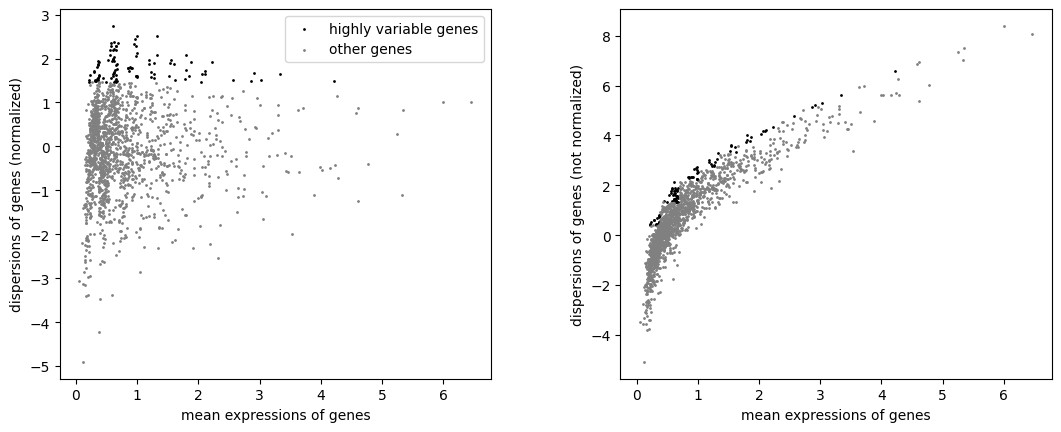

In [132]:
sc.pp.highly_variable_genes(adata, n_top_genes=100, flavor='seurat')
sc.pl.highly_variable_genes(adata)


In [53]:
corr_ids = np.argwhere(adata.var['highly_variable']).ravel()
# corr_ids
sorted_corr_ids = corr_ids[np.argsort(adata[:, corr_ids].var['highly_variable_rank'].values)[::-1]]
adata[:, sorted_corr_ids].var

KeyError: 'highly_variable'

# EVALUATE

In [70]:
data.columns[sorted_corr_ids]

Index(['MSTRG.24372.1', 'ENST00000562938.6', 'MSTRG.30797.34',
       'ENST00000636170.1', 'ENST00000368732.5', 'ENST00000414562.1',
       'MSTRG.29364.2', 'MSTRG.27407.13', 'MSTRG.21565.34',
       'ENST00000390517.1',
       ...
       'MSTRG.15201.6', 'ENST00000641834.2', 'MSTRG.35493.2', 'MSTRG.31745.5',
       'MSTRG.3370.10', 'MSTRG.14239.13', 'ENST00000654988.1',
       'ENST00000476562.5', 'MSTRG.29498.18', 'MSTRG.28762.46'],
      dtype='object', length=1034)

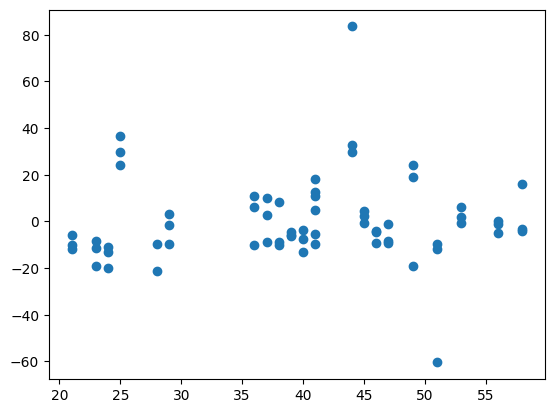

In [71]:
# # plt.figure(figsize=(16,6))
# sns.scatterplot(
#     y=np.abs(rhos[sorted_corr_ids]), 
#     x=data.columns[sorted_corr_ids],
#     )
# plt.xticks(rotation=90)


# X = data[data.columns[sorted_corr_ids[:n_features]]].values
# y = data_header['Age'].loc[data_header['sex'] == sex].values

from sklearn.decomposition import PCA

pca = PCA(None)
X_trainsformed = pca.fit_transform(data_female)
# plt.plot(X_trainsformed[:,0], X_trainsformed[:,1], 'o')
# plt.plot(X_trainsformed[:,0], X_trainsformed[:,1], 'o')
plt.plot(data_header_female['Age'], X_trainsformed[:,3], 'o')
# plt.plot(data_header_both['Age'], X_trainsformed[:,0], 'o')

In [72]:
data.columns[sorted_corr_ids], len(sorted_corr_ids) 

(Index(['MSTRG.24372.1', 'ENST00000562938.6', 'MSTRG.30797.34',
        'ENST00000636170.1', 'ENST00000368732.5', 'ENST00000414562.1',
        'MSTRG.29364.2', 'MSTRG.27407.13', 'MSTRG.21565.34',
        'ENST00000390517.1',
        ...
        'MSTRG.15201.6', 'ENST00000641834.2', 'MSTRG.35493.2', 'MSTRG.31745.5',
        'MSTRG.3370.10', 'MSTRG.14239.13', 'ENST00000654988.1',
        'ENST00000476562.5', 'MSTRG.29498.18', 'MSTRG.28762.46'],
       dtype='object', length=1034),
 1034)

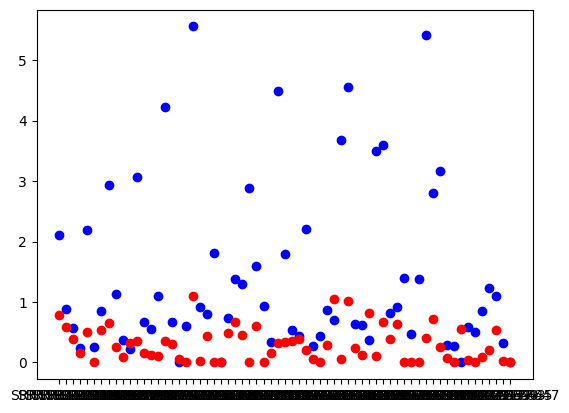

In [73]:
plt.plot(data.loc[data_header['sex'] == sex][data.columns[sorted_corr_ids][0]], 'bo')
plt.plot(data.loc[data_header['sex'] == sex][data.columns[sorted_corr_ids][1]], 'ro')

In [74]:
data.loc[data_header['sex'] == sex][data.columns[sorted_corr_ids][0]]

SRR19147434    2.106808
SRR19147442    0.878456
SRR19147446    0.566716
SRR19147447    0.243563
SRR19147449    2.192655
                 ...   
SRR19147639    0.856650
SRR19147640    1.235301
SRR19147643    1.103090
SRR19147645    0.324511
SRR19147647    0.000000
Name: MSTRG.24372.1, Length: 65, dtype: float32

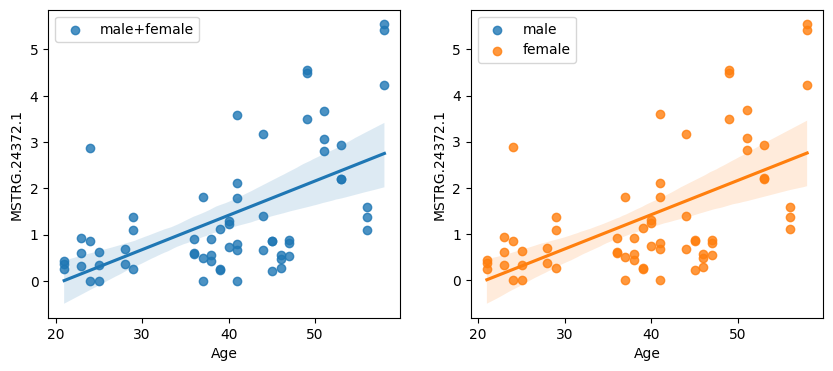

In [75]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
sns.regplot(y=data[data.columns[sorted_corr_ids[0]]], x=data_header['Age'], ax=axs[0], label='male+female')
sns.regplot(y=data[data.columns[sorted_corr_ids[0]]].loc[data_header['sex'] == 'male'], x=data_header['Age'].loc[data_header['sex'] == 'male'], ax=axs[1], 
            label='male')
sns.regplot(y=data[data.columns[sorted_corr_ids[0]]].loc[data_header['sex'] == 'female'], x=data_header['Age'].loc[data_header['sex'] == 'female'], ax=axs[1], 
            label='female')
axs[0].legend()
axs[1].legend()

In [76]:
data

,ENST00000003912.7,ENST00000004103.8,ENST00000005340.10,ENST00000006658.11,ENST00000011473.6,ENST00000012134.7,ENST00000019019.6,ENST00000040877.2,ENST00000043402.8,ENST00000070846.11,...,MSTRG.9920.54,MSTRG.9929.23,MSTRG.9929.7,MSTRG.993.1,MSTRG.9947.1,MSTRG.9948.7,MSTRG.9968.1,MSTRG.9975.19,MSTRG.9996.5,MSTRG.9996.8
SRR19147434,0.035113,0.000000,0.000000,0.000000,2.541312,1.165357,0.000000,0.000000,0.000000,1.324862,...,0.439607,0.412652,0.962864,0.161302,0.481970,0.112381,0.045710,2.256034,1.917703,0.000000
SRR19147442,0.000000,0.794052,0.639125,2.711348,1.775380,0.000000,0.064382,0.000000,0.050570,0.000000,...,0.402106,0.149464,0.113675,1.355619,0.250905,0.377805,0.050970,0.017744,2.300946,0.799852
SRR19147446,0.074349,0.753136,0.708915,0.000000,1.378070,2.801095,0.000000,0.000000,0.000000,0.493102,...,0.248560,0.000000,0.862037,1.057980,0.000000,0.358265,0.618596,0.000000,1.235949,0.619376
SRR19147447,0.090973,0.000000,0.477256,0.000000,2.109113,0.577190,0.000000,0.404090,0.060731,1.621448,...,0.361008,0.000000,0.109881,0.000000,0.791788,1.235325,1.264548,1.040307,0.000000,0.000000
SRR19147449,3.216066,0.000000,0.231375,2.159864,1.795123,2.483123,0.205097,0.644347,0.000000,1.492418,...,0.000000,0.617182,0.000000,0.000000,0.301595,1.491003,0.203924,0.000000,1.878485,0.302905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR19147639,0.018694,1.439938,0.000000,0.871802,0.812680,1.920269,1.853739,0.373347,1.485324,0.352790,...,0.682039,0.105977,0.048169,0.440572,0.138066,1.424093,0.904682,0.000000,1.860002,0.379787
SRR19147640,0.067368,0.853492,0.959471,0.000000,2.188290,0.368054,0.105354,0.923482,1.733386,0.000000,...,0.000000,0.172310,0.131330,0.000000,0.000000,0.000000,0.118245,0.000000,0.000000,0.000000
SRR19147643,0.053578,0.871527,0.000000,1.673051,0.000000,0.000000,0.029692,0.000000,0.000000,0.051819,...,0.000000,0.000000,0.000000,0.990722,0.193961,1.102999,0.155117,0.000000,3.188317,0.601204
SRR19147645,0.018633,0.229080,0.795503,0.975072,3.027320,0.000000,0.279622,0.413792,1.840818,0.045711,...,0.000000,0.000000,0.123792,0.000000,0.742506,0.167535,0.050493,0.000000,1.644255,0.110735


In [77]:
from statsmodels.genmod.generalized_linear_model import GLM

data_statsmod = sm.datasets.scotland.load()
data_statsmod.endog


0     60.3
1     52.3
2     53.4
3     57.0
4     68.7
5     48.8
6     65.5
7     70.5
8     59.1
9     62.7
10    51.6
11    62.0
12    68.4
13    69.2
14    64.7
15    75.0
16    62.1
17    67.2
18    67.7
19    52.7
20    65.7
21    72.2
22    47.4
23    51.3
24    63.6
25    50.7
26    51.6
27    56.2
28    67.6
29    58.9
30    74.7
31    67.3
Name: YES, dtype: float64

In [78]:
from linear_regressions_mixture import LinearRegressionsMixture



In [143]:
from sklearn.preprocessing import PolynomialFeatures


# n_features = 5
# n_features = -1

# sex = 'male'

print(data.shape[0])

for n_features in range(1, np.min([data.shape[0]+1, len(sorted_corr_ids)+1, 20])):
# for n_features in [2]:

    X = data[data.columns[sorted_corr_ids[:n_features]]].values
    y = data_header['Age'].loc[data_header['sex'] == sex].values

    
    # print(X.shape)
    print(f"{n_features=}")
    
    cv = StratifiedKFold(n_splits=5)
    # cv = LeaveOneOut()

    preds = []
    vals  = []
    gls_preds = []
    
    rmses = []
    r2s = []

    for i, (train, val) in tqdm(enumerate(cv.split(X, y))):
        X_train = X[train]
        y_train = y[train]
        X_test = X[val]
        y_test = y[val]

        # train_scaler = RobustScaler().fit(X_train)
        # test_scaler = RobustScaler().fit(X_test)
        # X_train = train_scaler.transform(X_train)
        # X_test = test_scaler.transform(X_test)

        X_train_ = X_train
        y_train_ = y_train
        
        X_val = X_test
        y_val = y_test
        
        # X_val = data_eval[data_eval.columns[sorted_corr_ids[:n_features]]].values
        # y_val = data_eval_header['Age'].loc[data_eval_header['sex']==sex].values

        poly = PolynomialFeatures(degree=2)
        X_train_ = poly.fit_transform(X_train_)
        X_val = poly.transform(X_val)
        
        # model = svm.SVR(kernel='linear')
        # model = svm.LinearSVR(loss='squared_epsilon_insensitive')
        model = LinearRegression()
        # model = Ridge()
        # model = XGBRegressor(n_estimators=300, max_depth=4, )
        # model = GridSearchCV(svm.SVR(kernel='rbf', gamma=0.1),
        #                      param_grid={"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-2, 2, 20)})    
        model.fit(X_train_, y_train_)
        pred = model.predict(X_val)
        
        # # print(f"{X_train_.shape=}")
        # # print(f"{X_val.shape=}")
        # epsilon = 1e-4
        # lam = 0.1
        # iterations = 50
        # random_restarts = 20
        # model = LinearRegressionsMixture(X_train_, np.expand_dims(y_train_, axis=1), K=2)
        # model.train(epsilon=epsilon, lam=lam, iterations=iterations, random_restarts=random_restarts, verbose=False)
        # pred = [model.predict(X_val[i]) for i in range(X_val.shape[0])]

        preds.extend(pred)
        vals.extend(y_val)
                
        # X_train_ = sm.add_constant(X_train_)
        # X_test = sm.add_constant(X_test, has_constant='add')
        
        # mod = sm.GLM(y_train_, X_train_,
        #              family=sm.families.NegativeBinomial()).fit()
        
        # gls_pred = mod.predict(X_test)
        # gls_preds.extend(gls_pred)
        

    print("RMSE: ", RMSE(np.ravel(preds), np.ravel(vals)))
    print("R2: ", r2_score(np.ravel(vals), np.ravel(preds)))
    # print("GLM RMSE: ", RMSE(gls_preds, vals))
    # print("GLM R2: ", r2_score(vals, gls_preds))
    
    # print("GLM RMSE: ", np.mean(rmses))
    # print("GLM R2: ", np.mean(r2s))
    
    # print(data.columns[sorted_corr_ids[:n_features]])
    print("-"*20)
    # print(model.coef_)
    # print(model.intercept_)

    # plt.plot(vals, "bo")
    # plt.plot(preds, "ro")
    # plt.show()

model.coef_

65
n_features=1


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 982.87it/s]


RMSE:  8.899944498638341
R2:  0.3011797070503235
--------------------
n_features=2


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 1006.02it/s]


RMSE:  7.764431566964115
R2:  0.4681241512298584
--------------------
n_features=3


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 865.05it/s]


RMSE:  7.57024512132959
R2:  0.4943956136703491
--------------------
n_features=4


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 797.37it/s]


RMSE:  6.961732117663352
R2:  0.5724120140075684
--------------------
n_features=5


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 797.37it/s]


RMSE:  7.1437566719964645
R2:  0.5497598052024841
--------------------
n_features=6


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 756.30it/s]


RMSE:  6.866899930368145
R2:  0.5839817523956299
--------------------
n_features=7


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 710.08it/s]


RMSE:  12.676466250202735
R2:  -0.41770970821380615
--------------------
n_features=8


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 678.49it/s]


RMSE:  49.17466593334974
R2:  -20.334074020385742
--------------------
n_features=9


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 640.96it/s]


RMSE:  97.28479867911314
R2:  -82.4989242553711
--------------------
n_features=10


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 680.28it/s]


RMSE:  50.61561097586851
R2:  -21.602678298950195
--------------------
n_features=11


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 626.48it/s]


RMSE:  33.23214713482902
R2:  -8.743338584899902
--------------------
n_features=12


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 657.44it/s]


RMSE:  33.823689173530504
R2:  -9.093293190002441
--------------------
n_features=13


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 501.70it/s]


RMSE:  23.213951797845688
R2:  -3.7543282508850098
--------------------
n_features=14


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 548.59it/s]


RMSE:  16.899617196382202
R2:  -1.5196759700775146
--------------------
n_features=15


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 649.15it/s]


RMSE:  15.407559827798053
R2:  -1.094395637512207
--------------------
n_features=16


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 603.06it/s]


RMSE:  12.188429050649374
R2:  -0.31064891815185547
--------------------
n_features=17


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 98.66it/s]


RMSE:  12.104107916401238
R2:  -0.2925771474838257
--------------------
n_features=18


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 51.60it/s]


RMSE:  12.525465805207457
R2:  -0.3841358423233032
--------------------
n_features=19


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 140.15it/s]

RMSE:  11.858559676653195
R2:  -0.24066579341888428
--------------------


array([-0.01069618,  0.5204722 ,  0.30520982,  0.48694652,  0.40619218,
       -0.10291445,  0.25516742, -1.5162516 ,  0.10640472,  0.0536387 ,
        1.0922313 , -0.09469913,  0.20447004, -0.11666071,  0.1698215 ,
       -0.93032134,  0.23800164,  0.14857602,  0.15300131,  0.15817048,
       -0.03240842,  0.5211909 ,  0.17946893, -0.63800883, -0.76982987,
       -0.33097678,  0.94012505, -0.62333226,  0.23318565,  0.86658067,
        0.07891309,  0.8928139 , -0.23482582, -0.3333946 ,  0.74642396,
       -0.42785597, -0.224343  , -0.20256454, -0.00993347, -0.07019864,
        0.08324987,  0.41026947,  0.8333471 , -0.03533639, -0.09396482,
       -0.19056512,  0.0722425 ,  0.58542836, -0.12434527, -0.0152052 ,
       -0.18025583,  0.03386137,  0.02794046,  0.18819673,  0.30404165,
        0.20624292,  0.07449219,  0.07200271,  0.12102911,  1.2370276 ,
        0.22098112,  1.634661  ,  0.2126964 ,  0.24483277,  0.30567873,
       -0.0241844 , -0.703358  ,  0.02377431,  0.7969569 ,  0.79

65
n_features=8


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 72.78it/s]

RMSE:  7.5746843771495405
MAE:  5.924923504644643
R2:  0.4938024631507115


array([[ 1.81076176e-01,  2.14898557e+00,  2.55860760e+00,
         1.88183512e+00,  3.77283893e-03,  4.11221349e+00,
        -4.92529752e-01,  1.41420444e+00]])

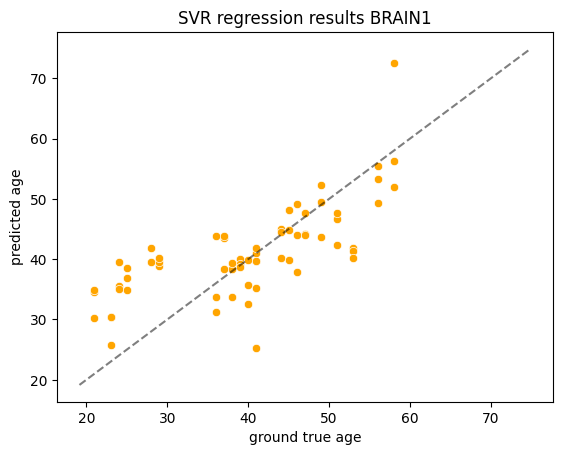

In [141]:
# n_features = 5
# n_features = -1

# sex = 'male'
print(data.shape[0])

# n_features = n_opt_features[organ][sex]
n_features = 8

X = data[data.columns[sorted_corr_ids[:n_features]]].values
y = data_header['Age'].loc[data_header['sex'] == sex].values

# print(X.shape)
print(f"{n_features=}")



cv = StratifiedKFold(n_splits=5)
# cv = LeaveOneOut()

preds = []
vals  = []
gls_preds = []

rmses = []
maes = []
r2s = []

for i, (train, val) in tqdm(enumerate(cv.split(X, y))):
    X_train = X[train]
    y_train = y[train]
    X_test = X[val]
    y_test = y[val]

    # train_scaler = RobustScaler().fit(X_train)
    # test_scaler = RobustScaler().fit(X_test)
    # X_train = train_scaler.transform(X_train)
    # X_test = test_scaler.transform(X_test)

    X_train_ = X_train
    y_train_ = y_train
    
    X_val = X_test
    y_val = y_test
    
    model = svm.SVR(kernel='linear')
    # model = svm.LinearSVR(loss='squared_epsilon_insensitive')
    # model = LinearRegression()
    # model = Ridge()
    # model = XGBRegressor(n_estimators=300, max_depth=4, )
    # model = GridSearchCV(svm.SVR(kernel='rbf', gamma=0.1),
    #                      param_grid={"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-2, 2, 20)})    
    model.fit(X_train_, y_train_)
    
    
    # X_train_ = sm.add_constant(X_train_)
    # X_test = sm.add_constant(X_test, has_constant='add')
    
    # mod = sm.GLM(y_train_, X_train_,
    #                 family=sm.families.NegativeBinomial()).fit()
    
    # gls_pred = mod.predict(X_test)
    # preds.append(gls_pred)
    
    pred = model.predict(X_val)
    preds.extend(pred)
    vals.extend(y_val)

print("RMSE: ", RMSE(np.ravel(preds), np.ravel(vals)))
# print("RMSE: ", RMSE(gls_preds, vals))
print("MAE: ", MAE(np.ravel(preds), np.ravel(vals)))
print("R2: ", r2_score(vals, preds))

# model.coef_

colors = {
    'male': 'blue',
    "female": "orange"
}

g = sns.scatterplot(
    x=np.array(vals).ravel(), 
    y=np.array(preds).ravel(), 
    color=colors[sex])
g.set_title(f"SVR regression results {organ}")
g.set_ylabel("predicted age")
g.set_xlabel("ground true age")

lims = [
    np.min([g.get_xlim(), g.get_ylim()]),  # min of both axes
    np.max([g.get_xlim(), g.get_ylim()]),  # max of both axes
]


g.plot(lims, lims, '--', color='k', alpha=0.5)

# g.set_xlim(lims)
# g.set_ylim(lims)

transcripts[organ][sex] = data.columns[sorted_corr_ids[:n_features]].tolist()
model.coef_


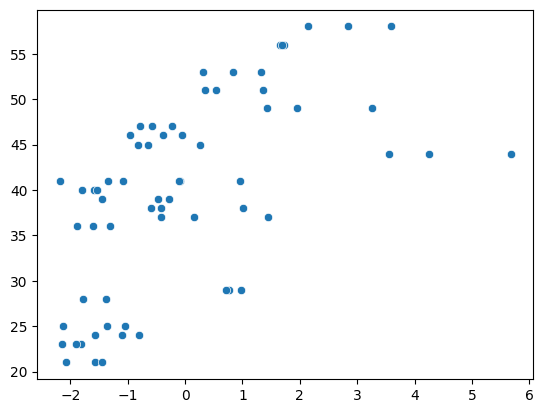

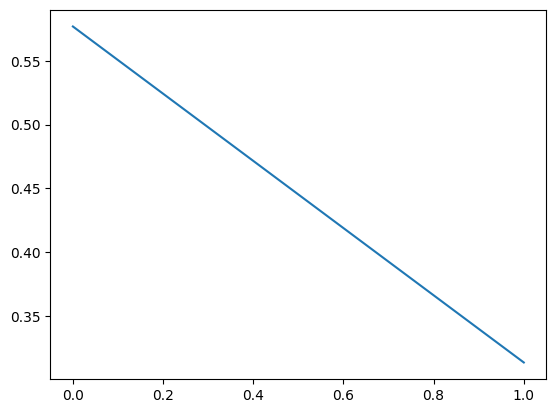

In [137]:
n_features = 5
X_ = data[data.columns[sorted_corr_ids[:n_features]]].values
y_ = data_header['Age'].loc[data_header['sex'] == sex].values
    
    
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_)
sns.scatterplot(x=X_pca[:, 0], y=y_)
# X_pca.shape
plt.figure()
plt.plot(pca.explained_variance_ratio_)

In [129]:
X_s

(65, 1033)

In [195]:
vals

[28,
 27,
 33,
 40,
 45,
 42,
 39,
 49,
 39,
 38,
 56,
 50,
 49,
 32,
 49,
 56,
 47,
 43,
 37,
 58,
 58,
 53,
 48,
 52,
 53,
 62,
 48,
 48,
 52,
 51,
 50,
 32,
 42,
 45,
 33,
 56,
 49,
 37,
 48,
 46,
 58,
 56,
 48,
 52,
 49,
 52,
 48,
 58,
 51,
 53,
 40,
 49,
 49,
 53,
 47,
 33,
 28,
 39,
 38,
 43,
 36,
 50,
 59,
 37,
 46,
 56,
 48,
 40,
 49,
 48,
 49,
 52,
 49,
 44,
 40,
 42,
 45,
 49,
 39,
 56,
 32,
 47,
 52,
 28,
 33,
 37,
 58,
 53,
 53,
 48,
 36,
 27,
 49,
 50,
 42,
 45,
 44,
 47,
 49,
 47,
 40,
 45,
 39,
 49,
 33,
 58,
 59,
 56,
 52,
 62,
 48,
 48,
 37,
 58,
 53,
 56,
 53,
 48,
 49,
 46,
 36,
 50,
 44,
 27,
 42,
 38,
 39,
 50,
 42,
 45,
 43,
 47,
 37,
 33,
 59,
 58,
 62,
 48,
 52,
 48,
 56,
 51,
 58,
 40,
 53,
 48,
 49,
 49,
 52,
 49]

(array([ 9.,  5.,  3.,  0., 12.,  9.,  9.,  6.,  6.,  6.]),
 array([21. , 24.7, 28.4, 32.1, 35.8, 39.5, 43.2, 46.9, 50.6, 54.3, 58. ]),
 <BarContainer object of 10 artists>)

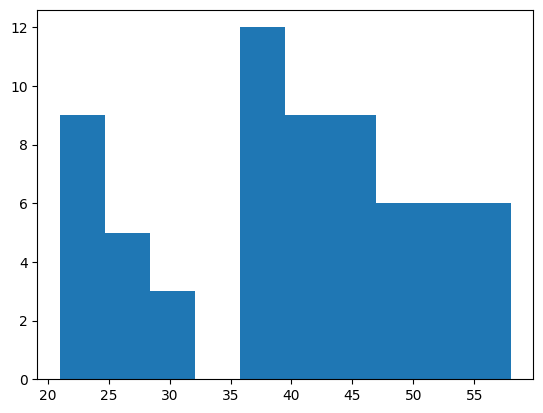

In [26]:
plt.hist(np.array(vals).ravel())

In [60]:
# import copy
# transcripts_dict = copy.deepcopy(transcripts)

# # for organ in ['BRAIN0', "HEART", "BRAIN1"]:
# #     for sex in ['female', 'male']:
# #         transcripts_dict[organ][sex] = [".".join(el.split(".")[:-1]) for el in transcripts_dict[organ][sex]]
# transcripts_dict


In [488]:
from supervenn import supervenn
from upsetplot import plot, UpSet, from_contents

Chromosomes:  female
['HEART'] : 
{'ENST00000687101.1', 'ENST00000519878.1', 'MSTRG.23364.2', 'ENST00000372841.8', 'ENST00000417040.1', 'ENST00000590632.1', 'ENST00000473301.1', 'ENST00000511757.1', 'ENST00000524627.5', 'ENST00000565500.5', 'ENST00000554243.1', 'MSTRG.27522.8', 'ENST00000366529.4', 'ENST00000466186.2', 'ENST00000679970.1', 'MSTRG.29296.55', 'ENST00000580063.1', 'ENST00000420515.1', 'MSTRG.11225.100', 'ENST00000556476.1'}
['BRAIN1'] : 
{'MSTRG.21417.7', 'MSTRG.30797.34', 'ENST00000519615.1', 'ENST00000689865.2', 'ENST00000437783.1', 'ENST00000569155.1', 'ENST00000409718.5', 'MSTRG.29364.2', 'ENST00000525549.5', 'MSTRG.17547.1', 'ENST00000543693.5', 'ENST00000656109.1', 'MSTRG.24372.1', 'ENST00000636170.1', 'ENST00000391138.1', 'ENST00000368732.5', 'MSTRG.31018.1', 'ENST00000414562.1', 'ENST00000336169.3', 'ENST00000675702.1', 'MSTRG.27407.13', 'ENST00000443037.1', 'ENST00000360415.7', 'ENST00000562938.6', 'ENST00000675559.1'}
['BRAIN0'] : 
{'ENST00000703798.1', 'MSTRG.4

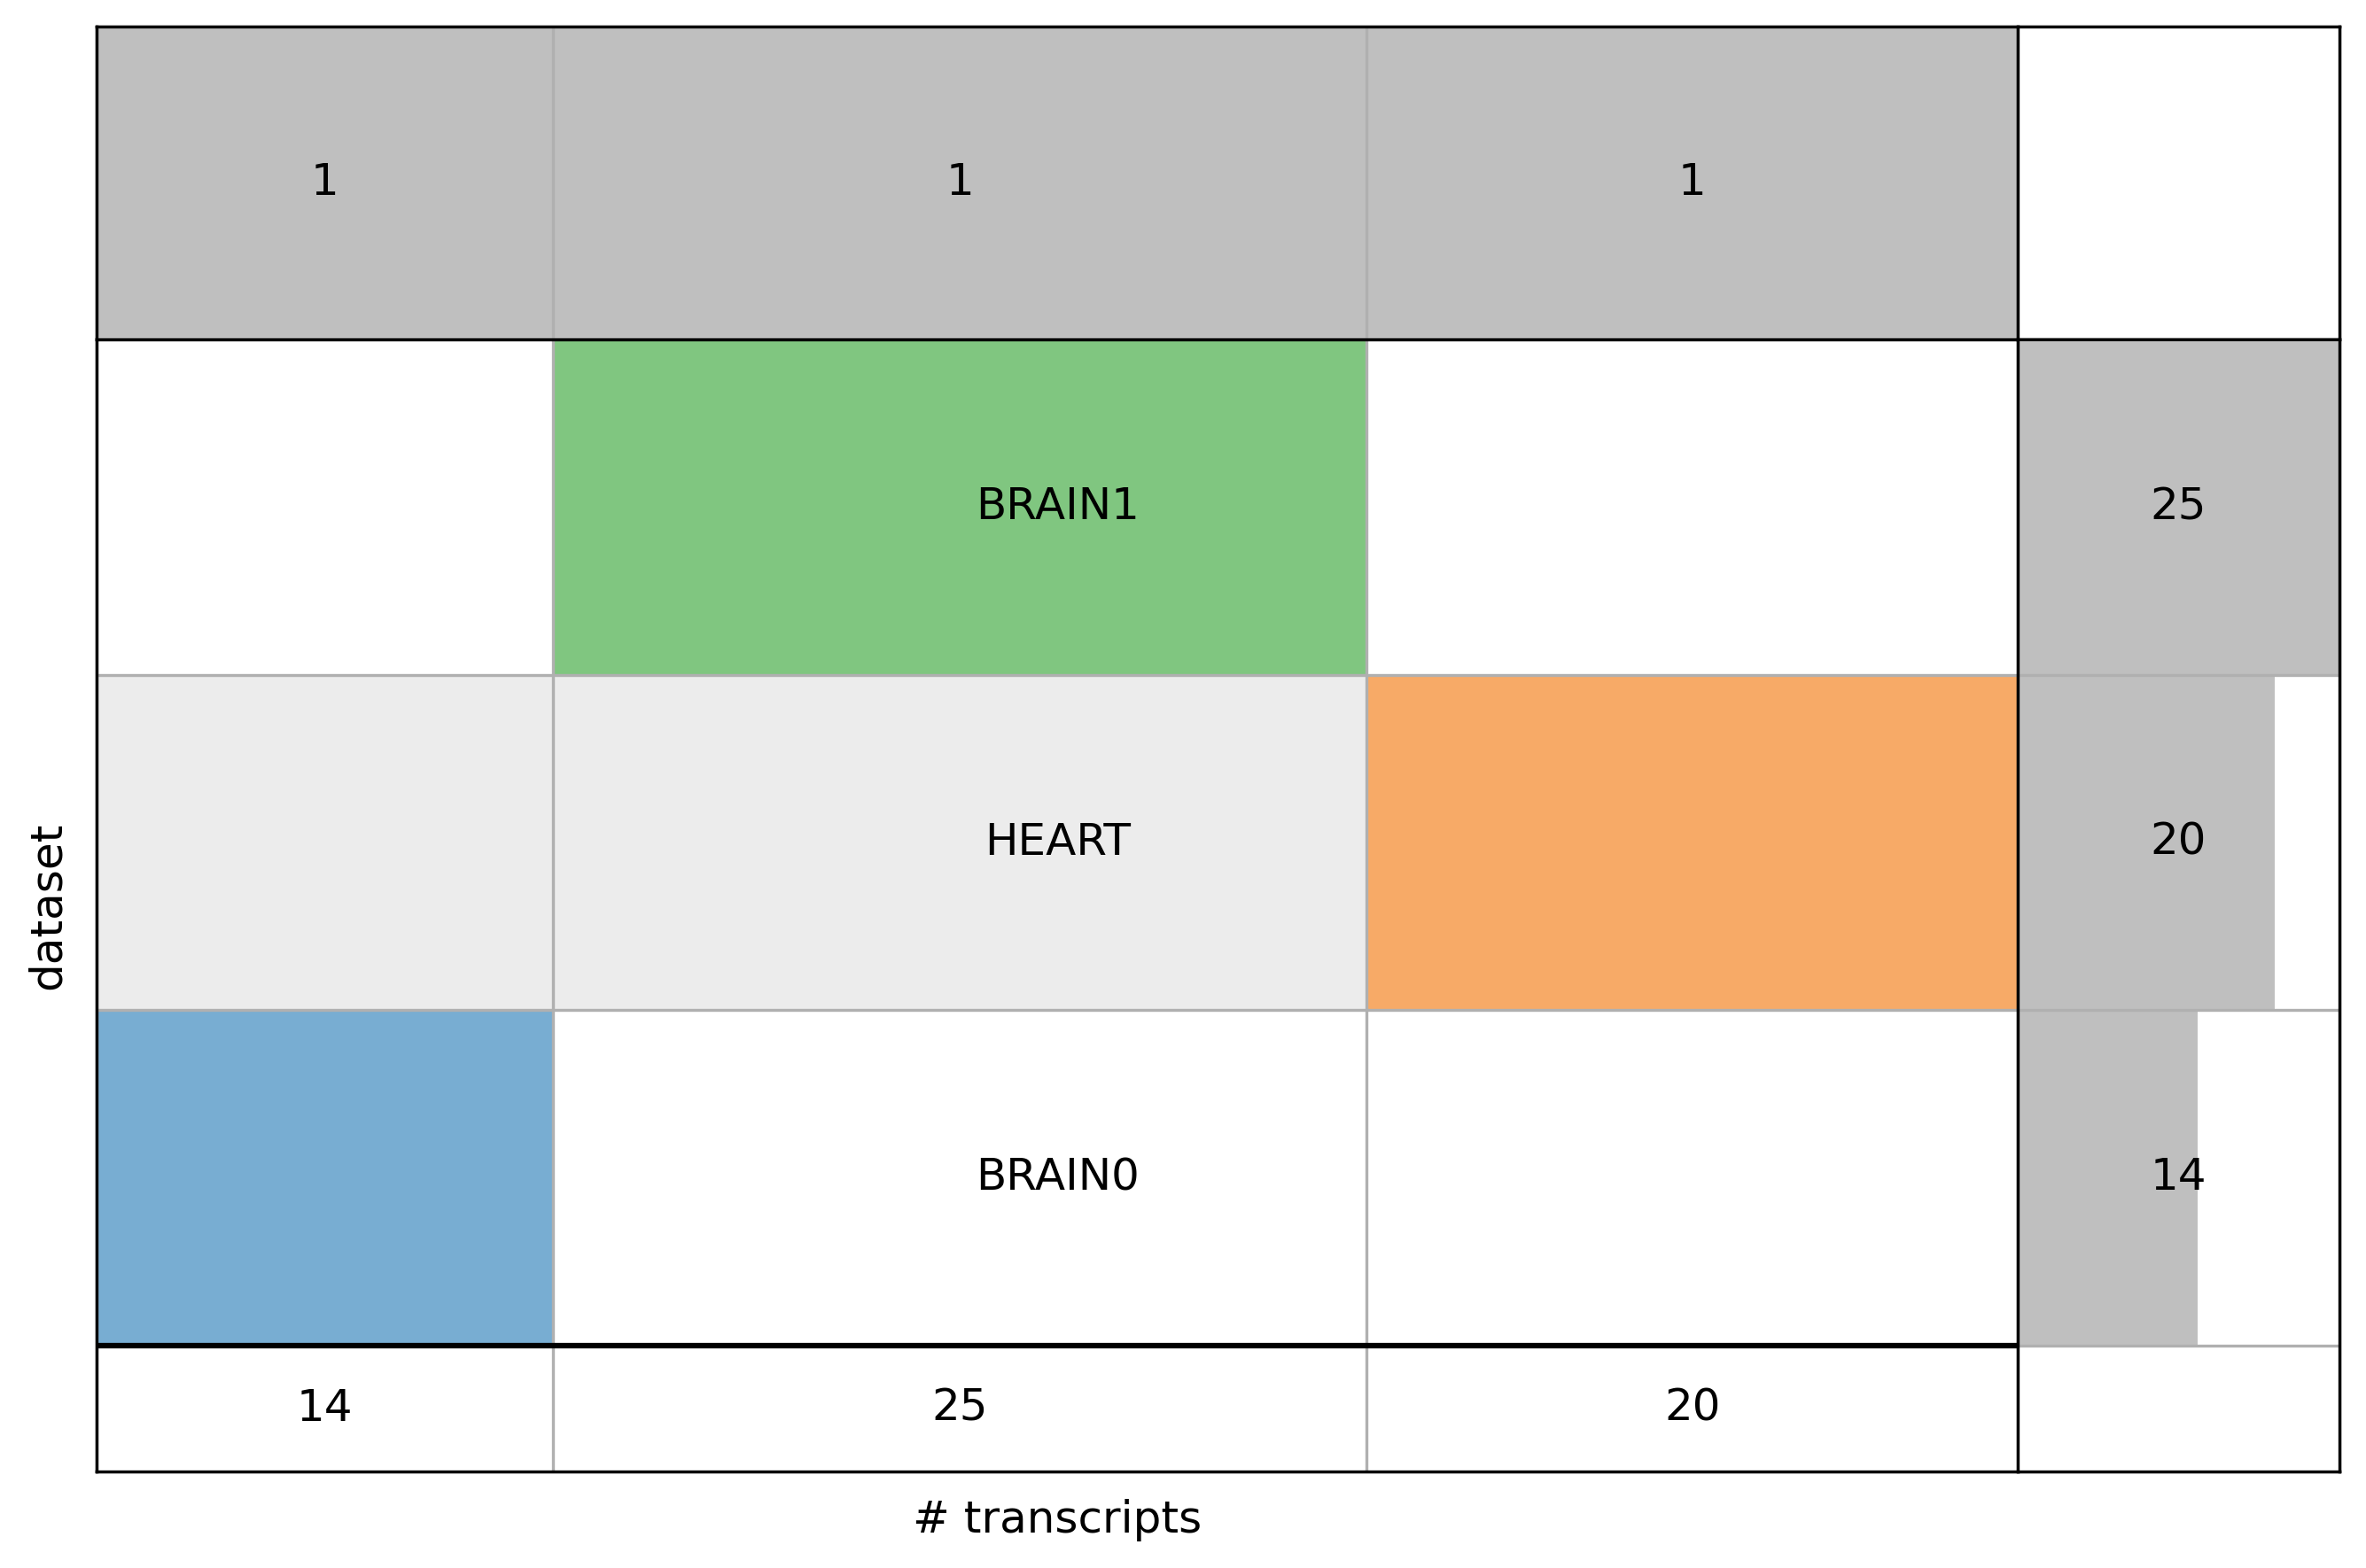

In [492]:

sex = ['male', 'female'][1]
test_dict = {}
for organ in ['BRAIN0', "HEART", "BRAIN1"]:
    # test_dict[organ] = set(transcripts_dict[organ][sex])
    test_dict[organ] = set(transcripts_dict[organ]['male']).union(set(transcripts_dict[organ]['female']))


plt.figure(figsize=(9, 6), dpi=300)
g = supervenn(list(test_dict.values()), list(test_dict.keys()),
        # sets_ordering="minimize gaps",
        chunks_ordering='minimize gaps',
        )
plt.title(sex)
plt.tight_layout()
g.axes['main'].set_xlabel('# transcripts')
g.axes['main'].set_ylabel('dataset')


print("Chromosomes: ", sex)
for el in list(g.chunks.keys()):
    print(np.array(list(test_dict.keys()))[list(el)], ": ")
    print(g.chunks[el])
    # print(adata.var['gene_name'][list(g.chunks[el])])


Organ:  HEART
['male'] : 
{'ENST00000687101.1', 'ENST00000417040.1', 'ENST00000565500.5', 'ENST00000590632.1', 'ENST00000580063.1', 'MSTRG.23364.2', 'ENST00000473301.1', 'ENST00000511757.1', 'MSTRG.27522.8'}
['female'] : 
{'ENST00000466186.2', 'ENST00000519878.1', 'ENST00000679970.1', 'MSTRG.29296.55', 'ENST00000420515.1', 'MSTRG.11225.100', 'ENST00000554243.1', 'ENST00000524627.5', 'ENST00000366529.4', 'ENST00000556476.1', 'ENST00000372841.8'}


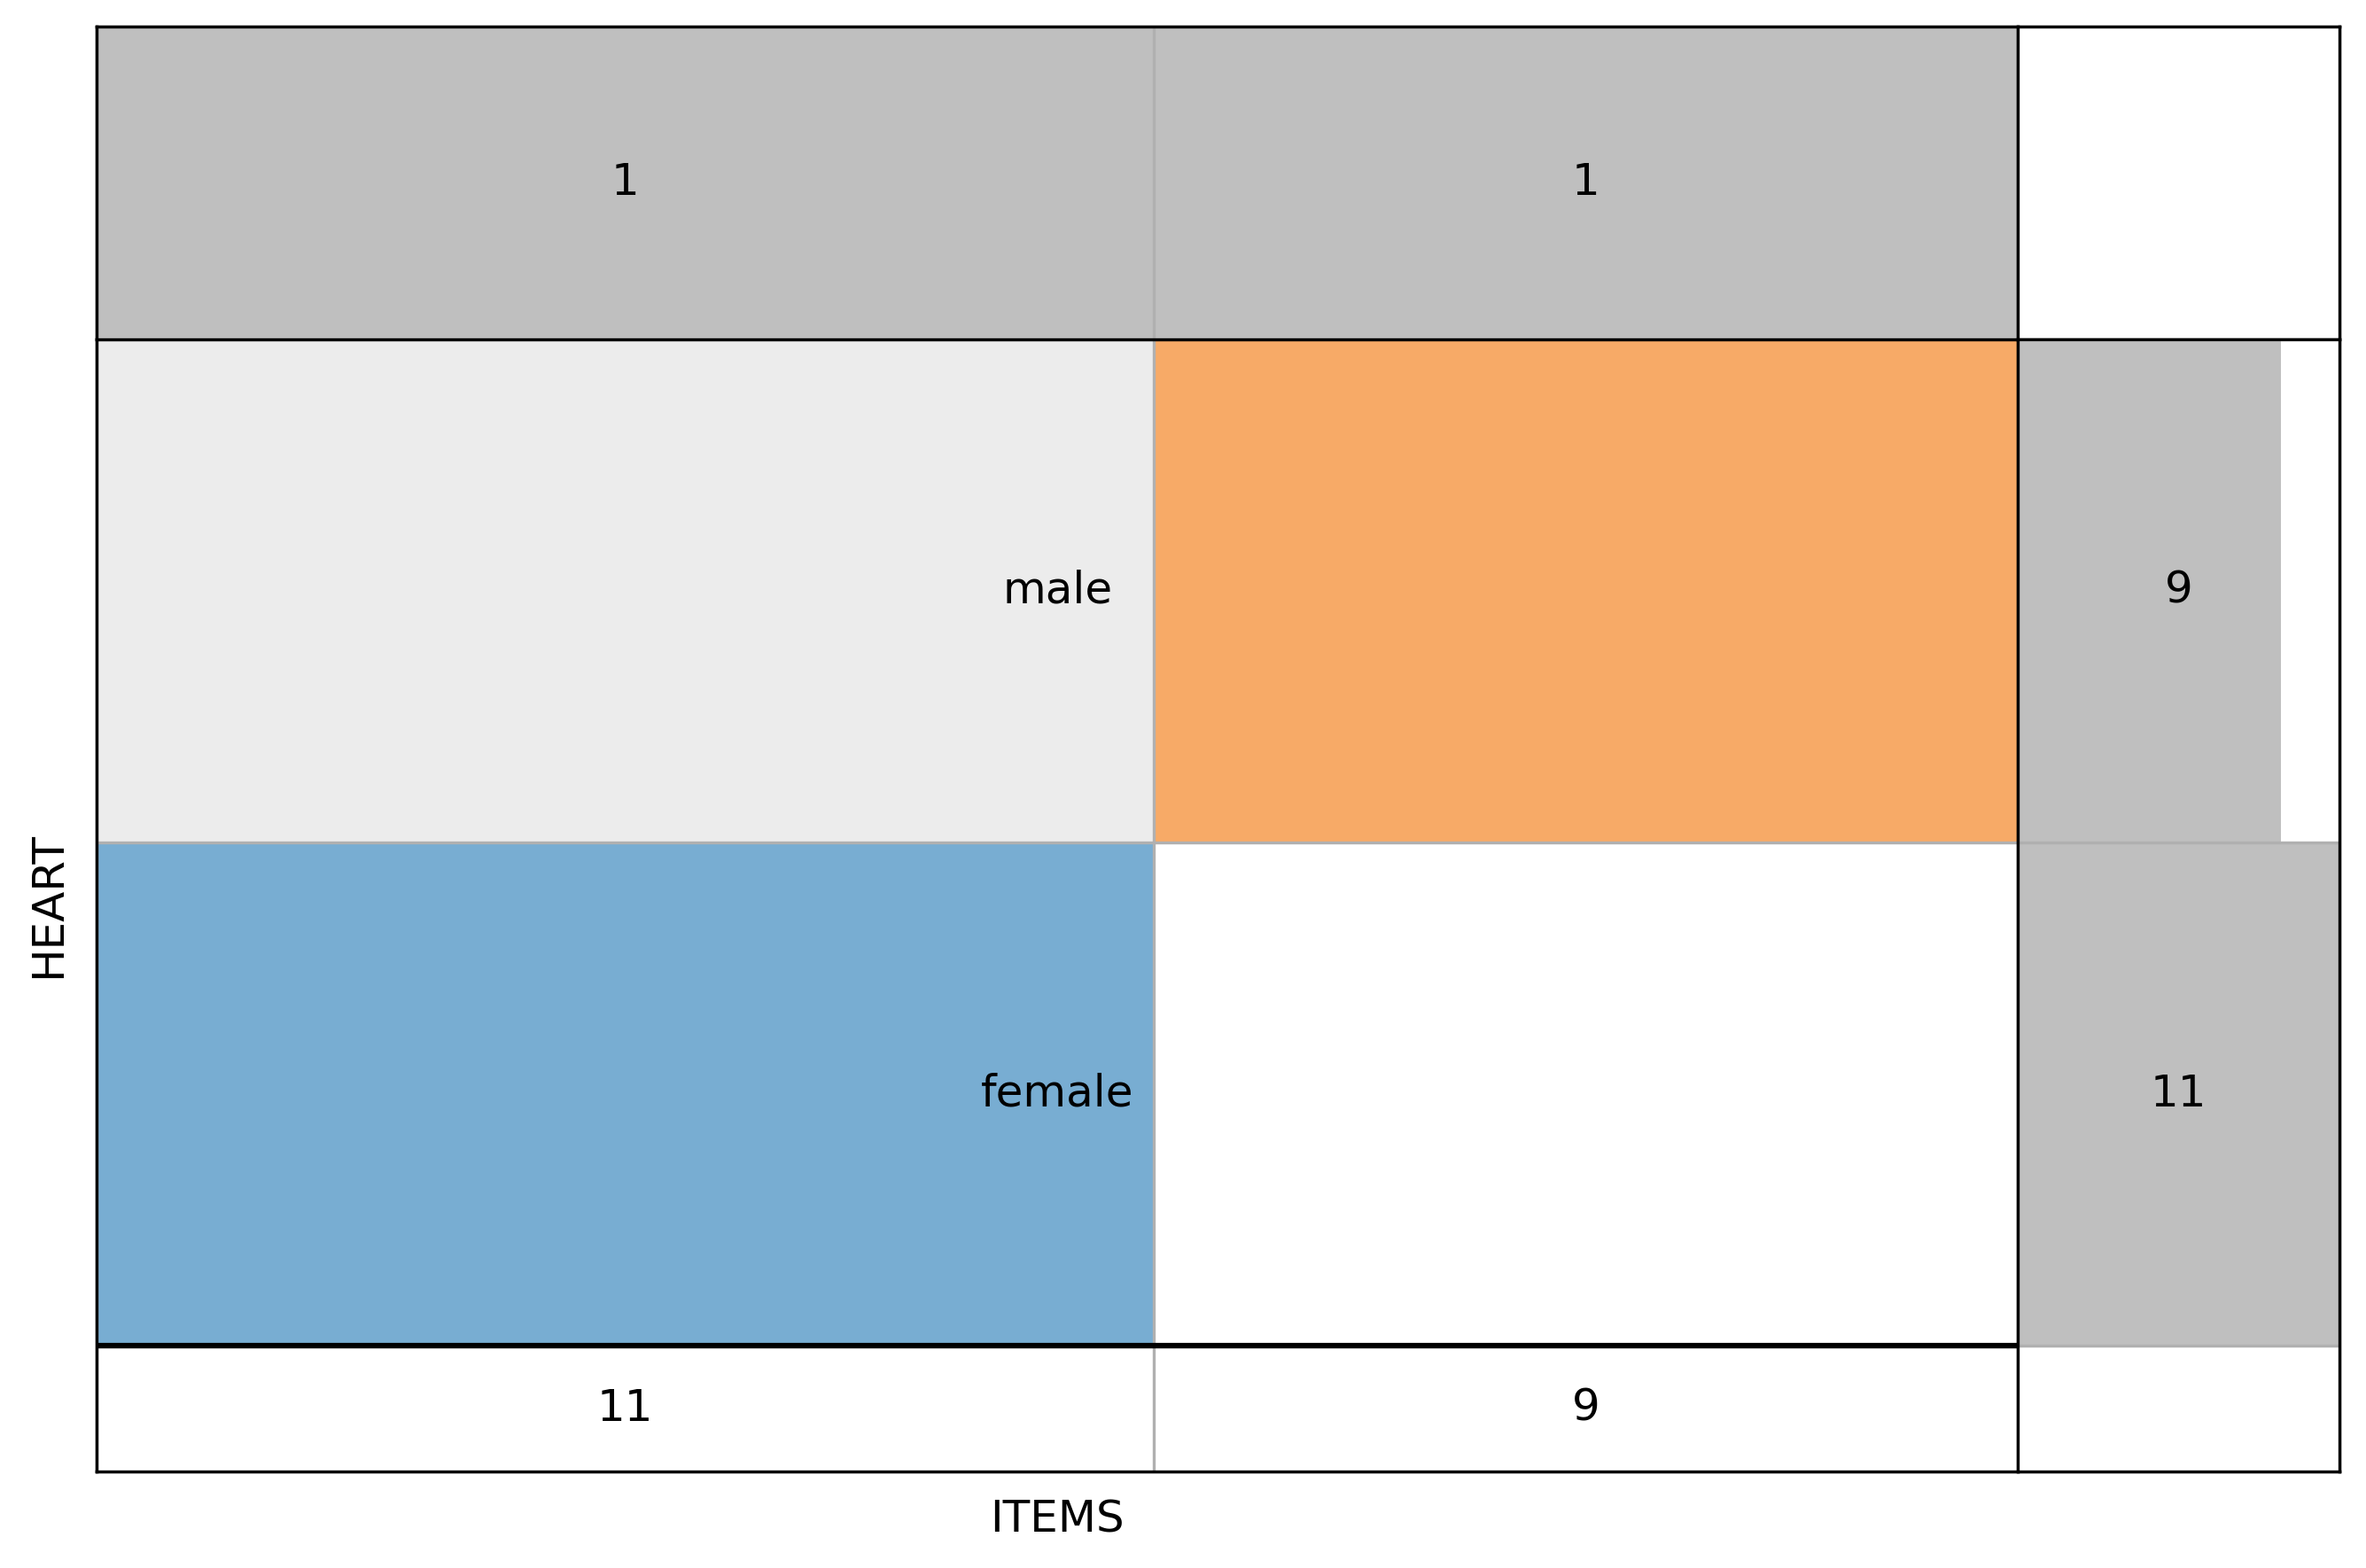

In [490]:
organ = ['BRAIN0', "HEART", "BRAIN1"][1]
test_dict = {}
for sex in ['male', 'female']:
    test_dict[sex] = set(transcripts_dict[organ][sex])

# UpSet(from_contents(test_dict), show_counts=True).plot()

plt.figure(figsize=(9, 6), dpi=300)
g = supervenn(list(test_dict.values()), list(test_dict.keys()),
        sets_ordering="minimize gaps",
        chunks_ordering='minimize gaps')
plt.title(sex)
plt.tight_layout()

g.axes['main'].set_ylabel(organ)

print("Organ: ", organ)
for el in list(g.chunks.keys()):
    print(np.array(list(test_dict.keys()))[list(el)], ": ")
    print(g.chunks[el])


<Axes: >

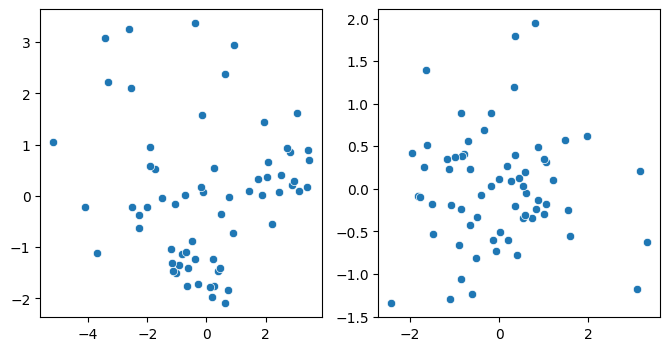

In [491]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures

reducer = PCA(n_components=4)

X_transformed = reducer.fit_transform(X)

fig, axs = plt.subplots(ncols=2, figsize=(8, 4))

sns.scatterplot(x=X_transformed[:, 0], y=X_transformed[:, 1], ax=axs[0])
sns.scatterplot(x=X_transformed[:, 2], y=X_transformed[:, 3], ax=axs[1])
# sns.scatterplot(x=X[:, 2], y=X[:, 3], ax=axs[1])
